In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data

# plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [3]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

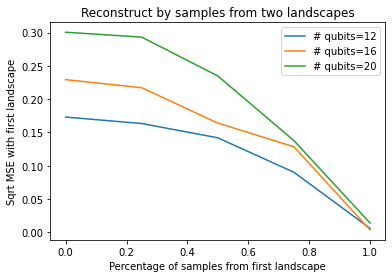

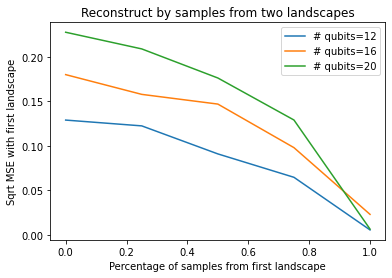

In [4]:
def cs_by_distributed_landscapes(config1: int, config2: int):
    if config1 == 1 and config2 == 2:
        data_paths = [
            "figs/recon_distributed_landscape/2022-11-05_12:51:53_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-05_12:53:56_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-05_12:55:51_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz"
        ]
    elif config1 == 2 and config2 == 3:
        data_paths = [
            "figs/recon_distributed_landscape/2022-11-10_13:47:08_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-10_13:51:25_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-10_13:56:38_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz"
        ]
    datas = []
    for data_dir in data_paths:
        datas.append(np.load(data_dir, allow_pickle=True))

    nqs = [12, 16, 20]

    fig = plt.figure(figsize=[6, 4])
    ax = plt.axes()
    # for nq in nqs:
    for nq, data in zip(nqs, datas):
        errors1 = data['errors1']
        ratios = data['ratios']
        ax.plot(ratios, errors1, label=f"# qubits={nq}")

    # ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
    ax.set_xlabel("Percentage of samples from first landscape")
    ax.set_ylabel("Sqrt MSE with first landscape")
    ax.set_title("Reconstruct by samples from two landscapes")
    plt.legend()
    fig.savefig("paper_figs/recon_error_by_distributed_LS.svg", bbox_inches='tight')
    plt.show()

    return
cs_by_distributed_landscapes(1, 2) # noise-1 and noise-2
cs_by_distributed_landscapes(2, 3) # noise-2 and noise-3

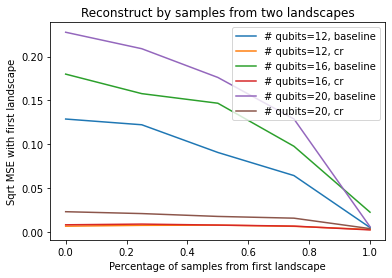

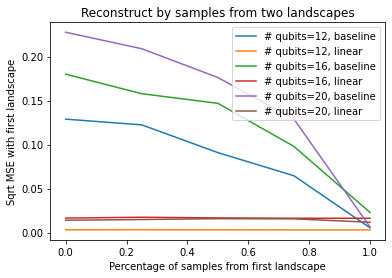

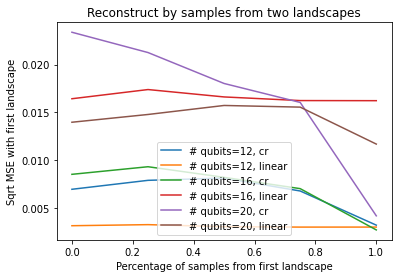

In [22]:
def vis_compare_normalization(data_paths1, data_paths2, labels: list):
    datas1 = []
    for data_dir in data_paths1:
        datas1.append(np.load(data_dir, allow_pickle=True))
    
    datas2 = []
    for data_dir in data_paths2:
        datas2.append(np.load(data_dir, allow_pickle=True))

    nqs = [12, 16, 20]
    # nqs = [12] #, 20]
    # nqs = [16] #, 20]

    fig = plt.figure(figsize=[6, 4])
    ax = plt.axes()
    # for nq in nqs:
    for i in range(len(nqs)):
        data1 = datas1[i]
        data2 = datas2[i]
    # for nq, data in zip(nqs, datas):
        errors1 = data1['errors1']
        errors2 = data2['errors1']
        # errors2 = [0.023518451284078853, 0.023456924971035843, 0.02065945117120222, 0.017619563122695157, 0.005215642521686432]
        ratios = data1['ratios']
        ax.plot(ratios, errors1, label=f"# qubits={nqs[i]}, {labels[0]}")
        ax.plot(ratios, errors2, label=f"# qubits={nqs[i]}, {labels[1]}")

    # ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
    ax.set_xlabel("Percentage of samples from first landscape")
    ax.set_ylabel("Sqrt MSE with first landscape")
    ax.set_title("Reconstruct by samples from two landscapes")
    plt.legend()
    fig.savefig("paper_figs/recon_error_by_distributed_LS_normalized.svg", bbox_inches='tight')
    plt.show()


def compare_recon_dist_with_normalize(method1: str, method2: str):
    # baseline
    baseline_paths = [
        "figs/recon_distributed_landscape/2022-11-10_13:47:08_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
        "figs/recon_distributed_landscape/2022-11-10_13:51:25_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
        "figs/recon_distributed_landscape/2022-11-10_13:56:38_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz"
    ]

    # linear regression
    linear_paths = [
        "figs/recon_distributed_landscape/2022-11-13_15:11:22/dist_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=linear-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_15:08:48/dist_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=linear-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_15:01:42/dist_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=linear-norm_frac=0.100.npz"
    ]

    # CR
    cr_paths = [
        "figs/recon_distributed_landscape/2022-11-13_14:03:00/dist_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=geo-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_14:05:55/dist_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=geo-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_14:11:40/dist_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=geo-norm_frac=0.100.npz"
    ]

    def get_paths(method):
        if method == 'linear':
            return linear_paths
        elif method == 'baseline':
            return baseline_paths
        elif method == 'cr':
            return cr_paths

    vis_compare_normalization(data_paths1=get_paths(method1), data_paths2=get_paths(method2),
        labels=[method1, method2])

    return
    
compare_recon_dist_with_normalize("baseline", "cr")
compare_recon_dist_with_normalize("baseline", "linear")
compare_recon_dist_with_normalize("cr", "linear")

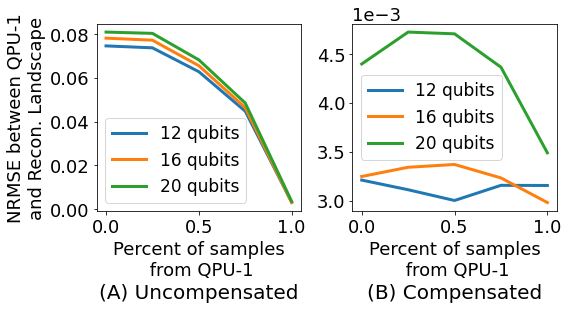

In [7]:
def one(ax, ratios, nqs, errors):

    for i in range(len(nqs)):
        # ax.plot(ratios, errors[i], label=f"{nqs[i]} qubits, {labels[0]}")
        ax.plot(ratios, errors[i], label=f"{nqs[i]} qubits", linewidth=3)
    # ax.set_xlabel("Percent of samples from low-noise landscape")
    # ax.set_ylabel("NRMSE between low-noise \nand recon. landscape")
    ax.legend()


def vis_compare_normalization(data1, data2, labels: list):
    # nqs = [12, 16, 20]
    # nqs = [12] #, 20]
    # nqs = [16] #, 20]
    params = {'legend.fontsize': 17,
          'figure.figsize': (8, 5),
         'axes.labelsize': 18, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
    plt.rcParams.update(params)
    # fig = plt.figure(figsize=[6, 4])
    fig, axs = plt.subplots(nrows=1, ncols=2)
    errors1 = data1['errors1']
    errors2 = data2['errors1']
    ratios = data1['ratios']
    nqs = data1['n_qubits_list']

    one(axs[0], ratios, nqs, errors1)
    one(axs[1], ratios, nqs, errors2)
    
    axs[0].set_title("(A) Uncompensated", y=-0.5)
    axs[1].set_title("(B) Compensated", y=-0.5)
    axs[1].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    # axs[0].set_xlabel("Percent of samples from low-noise landscape")
    axs[0].set_xlabel("Percent of samples\n from QPU-1")
    axs[1].set_xlabel("Percent of samples\n from QPU-1")
        # ax.set_ylabel("NRMSE between low-noise \nand recon. landscape")
    # plt.ylabel("NRMSE between low-noise \nand recon. landscape")
    # fig.text(-0.08, 0.5, "NRMSE between low-noise and recon. landscape", va='center', rotation='vertical', fontsize=18)
    # fig.align_labels()
    axs[0].set_ylabel("NRMSE between QPU-1\nand Recon. Landscape")
    plt.tight_layout()
    plt.legend()
    fig.savefig("paper_figs/parallel_LS_recon_normalized.pdf", bbox_inches='tight', dpi=1000)
    plt.show()


def compare_recon_dist_with_normalize(method1: str, method2: str):
    # baseline
    def get_data(method):

        if method == 'baseline':
            path = "figs/recon_distributed_landscape/2022-11-20_19:52:35/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.000-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:42/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.000-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:42/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.000.npz"
        elif method == 'linear':
            path = "figs/recon_distributed_landscape/2022-11-20_19:49:11/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.100-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:56/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.100-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:56/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.100.npz"
        elif method == 'geo':
            path = "figs/recon_distributed_landscape/2022-11-13_16:49:14/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=geo-nf=0.100.npz"

        return np.load(path, allow_pickle=True)

    vis_compare_normalization(get_data(method1), get_data(method2), [method1, method2])

    return
    
# compare_recon_dist_with_normalize("baseline", "geo")
compare_recon_dist_with_normalize("baseline", "linear")
# compare_recon_dist_with_normalize("geo", "linear")